# Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader

plt.style.use('seaborn-v0_8-ticks')
%config InlineBackend.figure_formats =['png']
import copy

# Classes
- Early Stopper class
- Data

In [2]:
class EarlyStopping:
    """
    Parameters
    ----------
    patience : float
        How long should we wait until there are no improvements
    minDelta : float
        Small values, The minimum change that should be considered as an improvement.
    restoreBestWeights : bool
        Restore the best weight settings, when there is no overfitting!
    """

    def __init__(self, patience=5, minDelta=0, restoreBestWeights=True):
        # EarlyParams
        self.patience = patience
        self.minDelta = minDelta
        self.restoreBestWeights = restoreBestWeights
        self.best_epoch = 0
        # Restore Options
        self.bestModel = None
        self.bestLoss = None
        self.counter = 0
        self.status = 'Learning'

    def __call__(self, model, val_loss, epoch):

        if self.bestLoss is None:  # First Visit
            self.bestModel = copy.deepcopy(model.state_dict())
            self.bestLoss = val_loss
            self.best_epoch = epoch

        elif self.bestLoss - val_loss >= self.minDelta:  # check if there is any improvement
            self.bestModel = copy.deepcopy(model.state_dict())
            self.bestLoss = val_loss
            self.best_epoch = epoch
            self.counter = 0  # reset counting
            self.status = f'Learning'

        else:  # Means there are no improvements
            self.counter += 1
            self.status = f'Waiting.'
            if self.counter >= self.patience:  # Have we waited enough?
                self.status = f'*Finished due to no improvements on validation for {self.counter} epochs.'
                if self.restoreBestWeights:  # Restore Best weights ?
                    model.load_state_dict(self.bestModel)
                return True
        return False

### CNN Network output
<img src="https://miro.medium.com/v2/resize:fit:1400/1*17TNPi4m0pBqOCGrXzU27w.gif">

In [3]:
class CNN_Classifier(nn.Module):
    def __init__(self):
        super().__init__()

        '''
            @in_channels: Channels in the input (red, green, and blue).
            @out_channels: This defines the number of output channels or feature maps.
            @kernel_size: Filter size NxN
            @stride: steps as shown above
            @padding: adding zeros on edges
        '''
        ## Conv 1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5, stride=1, padding=1 )
        self.conv1_size = self.__conv_layer_out_size(28,5,1,1)
        self.pool1 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.pool1_size = self.__pool_layer_out_size(self.conv1_size,2,2)

        ## Conv 2
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5, stride=1, padding=1 )
        self.conv2_size = self.__conv_layer_out_size(self.pool1_size,5,1,1)
        self.pool2 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.pool2_size = self.__pool_layer_out_size(self.conv2_size,2,2)

        ## Fully connected layers
        self.fc_size = self.pool2_size**2 * 20   ## 20 is the conv2 size, and exponential is because we are flattening it.
        self.fc1 = nn.Linear(in_features=self.fc_size, out_features=50)
        self.fc2 = nn.Linear(in_features=50, out_features=10) # Output

    def __conv_layer_out_size(self,in_sz,k_size,padding,stride):
        return ( (in_sz - k_size + 2*padding) // stride ) + 1

    def __pool_layer_out_size(self,in_sz,k_size,stride):
        return ((in_sz - k_size) // stride) + 1

    def forward(self, x):
        # Conv
        x = F.relu( self.pool1( self.conv1(x) ) )
        x = F.relu( self.pool2( self.conv2(x) ) )

        # FC
        x = x.view(-1, self.fc_size) # Flatten data
        x = F.relu( self.fc1(x) )
        x = self.fc2(x) # To be processed after
        return x

In [4]:
'''
    - Create Training Batches that includes ( RealImage, TransformImage, Label ) in every batch, so calling Train_set[0] will return them.
'''
class My_New_MNIST(torch.utils.data.Dataset):
    def __init__(self, root, train, transform, download):
        self.original_dataset = datasets.MNIST(root=root, train=train, transform=transform, download=download)


        self.original_imgs = torch.stack([transforms.ToTensor() (img.detach().numpy()) for img in self.original_dataset.data])

        self.transformed_imgs = torch.stack([transform(img.detach().numpy()) for img in self.original_dataset.data])
        self.original_targets = self.original_dataset.targets


    def __getitem__(self, index):
        return self.original_imgs[index],self.transformed_imgs[index],self.original_targets[index]

    def __len__(self):
        return len(self.original_imgs)

In [5]:
from tqdm import tqdm


def calculate_accuracy(y, yHat):
    TP = (torch.argmax(yHat,axis=1) == y).float()
    return torch.mean(TP) * 100


class Training:
    def __init__(self,in_net,in_Loss_func,in_optimizer,in_train_loader,in_test_loader):
        # Network
        self.__net = in_net
        self.__loss_func = in_Loss_func
        self.__optimizer = in_optimizer
        self.__EarlyStopper = EarlyStopping(patience=20)

        # Data
        self.__train_loader = in_train_loader
        self.__test_loader = in_test_loader

        # Measures
        self.train_loss = []
        self.test_loss  = []
        self.train_acc  = []
        self.test_acc   = []

    def reset(self):
        self.train_loss = []
        self.test_loss  = []
        self.train_acc  = []
        self.test_acc   = []

    def train(self):
        self.reset()
        epoch_pb = tqdm(range(500),leave=True,position=0)

        for epoch in epoch_pb:
            batch_loss = []
            batch_acc = []
            self.__net.train()

            for X_orig,X_trans,y in self.__train_loader:
                # YHat
                yHat = self.__net.forward(X_trans)

                # Loss Func
                loss = self.__loss_func(yHat,y)
                batch_loss.append( loss.item() )

                # Batch Accuracy
                batch_acc.append(calculate_accuracy(y,yHat))

                # Backprop
                self.__optimizer.zero_grad()
                loss.backward()
                self.__optimizer.step()

            # Calculate training metrics
            self.train_loss.append( np.mean( batch_loss ) )
            self.train_acc.append( np.mean( batch_acc ) )

            # Test evaluating
            test_eval = self.eval()
            self.test_loss.append(test_eval[0])
            self.test_acc.append(test_eval[1])

            # Report
            epoch_pb.set_description(self.report(epoch))

            # Check for any model improvements
            if self.__EarlyStopper(self.__net, self.test_loss[-1], epoch):
                print(f'The model has completed its training with an accuracy of {np.max(self.test_acc):.3f}%, and loss of {np.min(self.test_loss):.3f}')
                break

    def eval(self):
        loss = None
        acc = None
        with torch.no_grad():
            self.__net.eval()

            X_origin,X_trans,y = next(iter(self.__test_loader))
            yHat = self.__net(X_trans)
            loss = self.__loss_func(yHat,y)
            accuracy = calculate_accuracy(y,yHat)

        return loss.item(),accuracy


    def report(self,epoch):
        return f'Epoch({epoch+1})' \
               f'-{self.__EarlyStopper.status}\t' \
               f'Training-( ' \
               f'Loss: {self.train_loss[-1]:.5f}   ' \
               f'Accuracy: {self.train_acc[-1]:.5f} )\t' \
               f'Testing-( ' \
               f'Loss: {self.test_loss[-1]:.5f}   ' \
               f'Accuracy: {self.test_acc[-1]:.5f} )'


# Data

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Grayscale(),
    transforms.RandomAffine(degrees=10,translate=(0.3,0.1))
])

train_set = My_New_MNIST(root='../data', train=False, transform=transform, download=False)

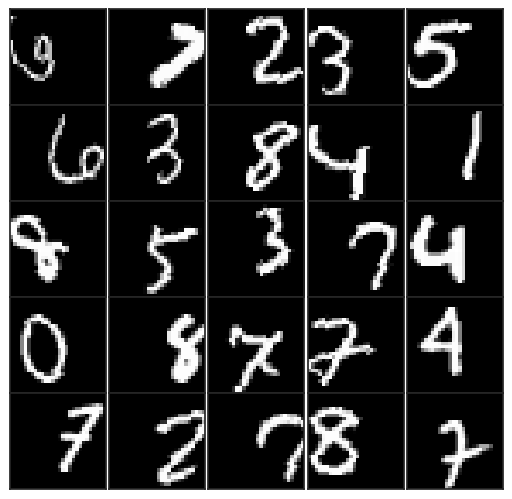

In [7]:
sample_size = 25
random_idxs = np.random.randint(0,1000,sample_size)
random_imgs = train_set[random_idxs][1]

for i, img in enumerate(random_imgs):
    plt.subplot(5,5,i+1)
    plt.imshow(img.reshape(28,28),cmap='gray')
    plt.xticks([]), plt.yticks([])
    plt.subplots_adjust(hspace=0, wspace=0, top=0, bottom=-1)
plt.show()

# Splitting data

In [8]:
# Percentage of split
train_size = int(0.9 * len(train_set))
test_size  = len(train_set) - train_size

# Train-Test Splits
train_dataset, test_dataset = torch.utils.data.random_split(train_set, [train_size,test_size])

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=521, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=test_size, shuffle=False, drop_last=True)

# Print results
print(f'TrainLoader has {train_loader.batch_size} elements and {len(train_loader)} batches = {train_loader.batch_size * len(train_loader)}')
print(f'TestLoader has {test_loader.batch_size} elements and {len(test_loader)} batches = {test_loader.batch_size * len(test_loader)}')

TrainLoader has 521 elements and 17 batches = 8857
TestLoader has 1000 elements and 1 batches = 1000


# Model

In [9]:
model = CNN_Classifier()
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
train_class = Training(in_net=model, in_Loss_func=loss_func, in_optimizer=optimizer, in_train_loader=train_loader,in_test_loader=test_loader)

In [10]:
train_class.train()

Epoch(37)-Waiting.	Training-( Loss: 0.00055   Accuracy: 100.00000 )	Testing-( Loss: 0.22403   Accuracy: 95.80000 ):   7%|▋         | 36/500 [00:47<10:11,  1.32s/it]

The model has completed its training with an accuracy of 96.000%, and loss of 0.156


# Model experiments

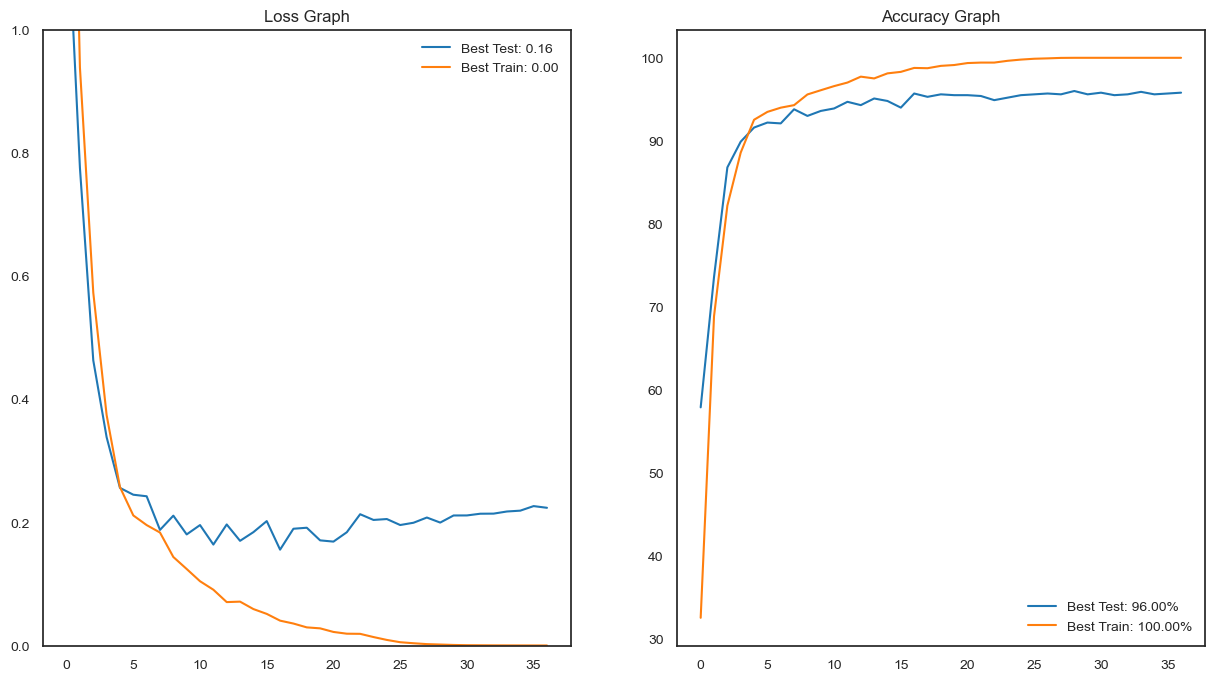

In [11]:
plt.figure(figsize=(15,8))

plt.subplot(1,2,1)
plt.title('Loss Graph')
plt.plot(train_class.test_loss,label=f'Best Test: {np.min(train_class.test_loss):.2f}')
plt.plot(train_class.train_loss,label=f'Best Train: {np.min(train_class.train_loss):.2f}')
plt.legend()
plt.ylim([0,1])

plt.subplot(1,2,2)
plt.title('Accuracy Graph')
plt.plot(train_class.test_acc,label=f'Best Test: {np.max(train_class.test_acc):.2f}%')
plt.plot(train_class.train_acc,label=f'Best Train: {np.max(train_class.train_acc):.2f}%')
plt.legend()
plt.show()

# Model Testing

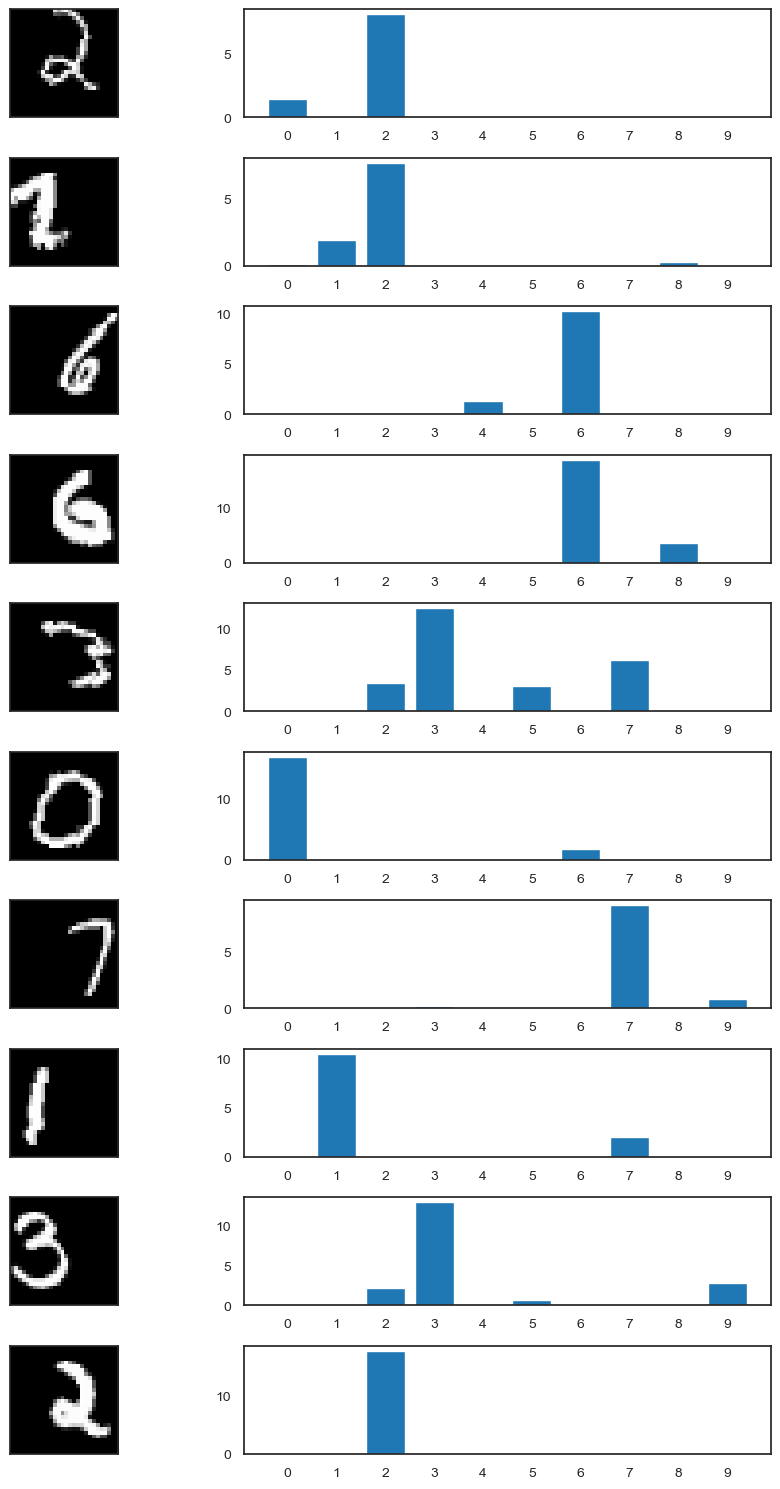

In [12]:
sample_size = 10
random_idxs = np.random.randint(0,1000,sample_size)
random_imgs = train_set[random_idxs][1]

model.eval()
yHat = model(random_imgs)

plt.figure(figsize=(10,15))

for i,img in enumerate(random_imgs):
    plt.subplot(sample_size,2,i*2+1)
    plt.imshow(img.squeeze(),cmap='gray')
    plt.yticks([]),plt.xticks([])

    plt.subplot(sample_size,2,i*2+2)
    plt.bar(x=np.arange(10),height=np.maximum(yHat[i].detach(),0))
    plt.xticks(np.arange(10))

plt.tight_layout()
plt.show()